<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Eletronics Purchase Prediction

Today you are a machine learning engineer in the Department of Marketing and Inventory at Walmart Labs. You have access to the Walmart server data, specifically the Electronics section. However, there is no customer facing information, but you do have access to timestamped data regarding product viewing/carting/purchasing. We will use this data to build a model of whether or not some product will be purchased.

Data is adapted from [e-commerce behavior data on Kaggle](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store). 

This file contains behavior data from a large multi-category store. Each row in the file represents an event. All events are related to products and users. Each event has a many-to-many relationship between users and products. 

## Learning Objectives

At the end of this session, you will be able to

- Leverage `pandas_profiling` for fast data understanding
- Practice data preprocessing
- Build logistic regression / SVM / Gradient Boosting
- Evaluate models with proper metrics
- Interpret black box models with SHAP
- Generate optimal pipeline for classification task using AutoML

## Task 1: Load data

Let's start by looking at the descriptions before loading in the csv files.

1. Use the `IPython.display` module to view the `some_column_descriptions.png` file. Look through the column names and descriptions to get an idea of what the data is.

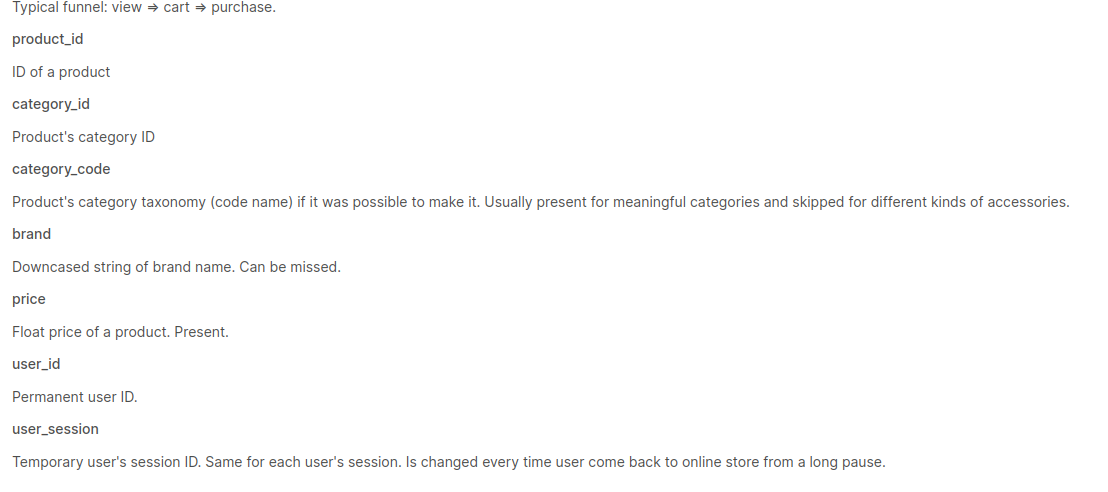

In [1]:
from IPython.display import Image, display
# change the filename to wherever you downloaded/uploaded the file
filename = '../img/some_column_descriptions.png'
display(Image(filename=filename))

The dataset has User-journey data, i.e., it tracks information on user/product pairs over time to see if the combination results in a purchase.

2. Look at the `user_journey_descriptions.png` file. Review the data sample to get a sense of what information we are tracking for each user/product pair.

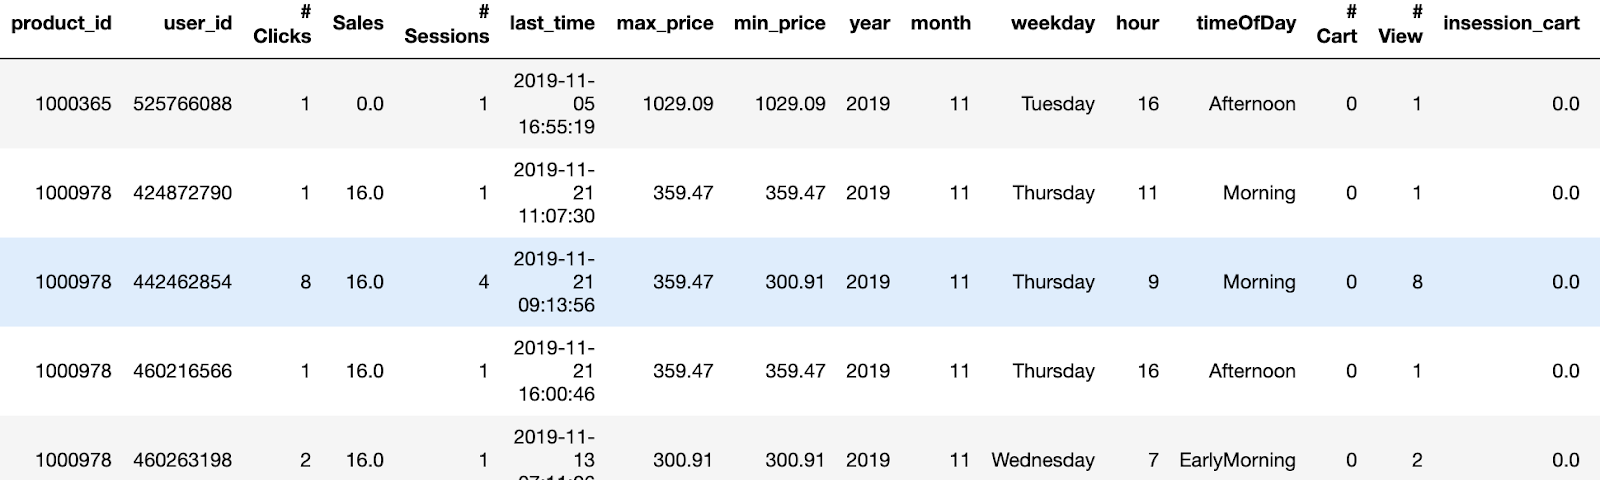

In [2]:
# change path to wherever you uploaded/downloaded the file
filename='../img/user_journey_descriptions.png'
display(Image(filename=filename))

The dataset we are working with is essentially what we have screenshotted above, but has been anonymized by removing product IDs and user IDs.

3. Use the pandas `read_csv()` and `head()` functions to read in the training data (`../dat/train.csv.gz`) and look at the first few rows.

    Note the `Purchase` column has values either 0 (not purchased) or 1 (purchased).

In [3]:
import pandas as pd
train_df = pd.read_csv('../dat/train.csv.gz', compression='gzip')

In [4]:
train_df.head(10)

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,InsessionCart,InsessionView,year,month,weekday,timeOfDay,Weekend,Purchase
0,1,1,0.0,154.41,154.41,0,1,0,1,2019,11,Sat,Morning,0,0
1,1,1,0.0,92.67,92.67,0,1,0,1,2019,11,Fr,Dawn,0,0
2,1,1,0.0,155.71,155.71,0,1,0,1,2019,11,Thu,Afternoon,0,0
3,1,1,0.0,898.32,898.32,0,1,0,1,2019,11,Mon,Noon,0,0
4,1,1,0.0,146.21,146.21,0,1,0,1,2019,11,Tue,Noon,0,0
5,1,1,0.0,244.54,244.54,0,1,0,1,2019,11,Sat,Noon,0,0
6,1,1,0.0,234.24,234.24,0,1,0,1,2019,11,Sat,Morning,0,0
7,1,1,0.0,463.31,463.31,0,1,0,1,2019,11,Wed,Evening,0,0
8,1,1,0.0,253.25,253.25,0,1,0,1,2019,11,Thu,Afternoon,0,0
9,1,1,0.0,450.18,450.18,0,1,0,1,2019,11,Mon,Morning,0,0


4. What is the dimension of the training data?

In [5]:
train_df.shape

(645816, 15)

5. Similarly, read in the test data `../dat/test.csv.gz` and check its dimension.

In [6]:
test_df = pd.read_csv('../dat/test.csv.gz', compression='gzip')
test_df.shape

(430544, 15)

## Task 2: Understand data

Our goal here is to predict whether a customer/product pair will result in a purchase. 
To do this, we will want to identify the most important features for classification. 

Before digging into each column, let's leverage `pandas_profiling`, that goes beyond `pd.DataFrame.describe()`, to get a big picture of our data set. 

1. From `pandas_profiling` import `ProfileReport`. 
    
    For faster iteration, create a profile report object `profile` with 10,000 samples from `train_df`. 
    
    Set its `title` as "Pandas Profiling Electronics Purchase Report". 
    
    For sampling, use `pd.DataFrame.sample(10000, randome_state=3)`. 

In [7]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train_df.sample(10000, random_state=3), title="Pandas Profiling Report")

   Show the report inside the notebook, go over the report and check each tab; especially the "Alerts". 

In [8]:
%%time
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 17.6 s, sys: 5.04 s, total: 22.6 s
Wall time: 12.6 s


2. Pandas profiling Profile reports that there are 4 numeric variables and 11 categorical variables. Let's print out the datatype of each feature (column) and understand how the profiler infers data type.

In [9]:
train_df.dtypes

NumOfEventsInJourney      int64
NumSessions               int64
interactionTime         float64
maxPrice                float64
minPrice                float64
NumCart                   int64
NumView                   int64
InsessionCart             int64
InsessionView             int64
year                      int64
month                     int64
weekday                  object
timeOfDay                object
Weekend                   int64
Purchase                  int64
dtype: object

3. From the report, we see that `year`, `month`, and `Weekend` were "Rejected" as there is only one distinct value for each column. 
These features are not informative, so we remove the three features from the training set. To do this, pass the `columns` argument to the `.drop()` method. 
Make sure to use `inplace=True` to modify the DataFrame. 
Print the shape of the DataFrames to verify the columns were dropped.

In [10]:
assert train_df.shape[1] == 15
train_df.drop(columns=['year', 'month', 'Weekend'], inplace=True)
assert train_df.shape[1] == 12

4. Repeat the steps for `test_df`:

In [11]:
test_df.drop(columns=['year', 'month', 'Weekend'], inplace=True)
assert test_df.shape[1] == train_df.shape[1]

5. As you can see from the profile report, `weekday` and `timeOfDay` each has 7 distinct values. 
Convert these non-numeric features to numeric. 

    These feature values are ordered temporally, so it makes sense to convert them to numeric type. 
    Follow the example given for the `weekday` column to update the `timeOfDay` column.
    Use the `.head()` method to inspect the dataset after the transformations.

In [12]:
weekday_str2num = {
    s: i+1 for i, s in enumerate(['Mon', 'Tue', 'Wed', 'Thu', 'Fr', 'Sat', 'Sun'])
}
train_df['weekday'] = train_df['weekday'].replace(weekday_str2num)
train_df['weekday'].unique()

array([6, 5, 4, 1, 2, 3, 7])

In [13]:
timeOfDay_str2num = {
    s: i+1 for i, s in enumerate(['Afternoon', 'EarlyMorning', 'Evening', 'Morning', 'Dawn', 'Noon', 'Night'])
}
train_df['timeOfDay'] = train_df['timeOfDay'].replace(timeOfDay_str2num)
train_df['timeOfDay'].unique()

array([4, 5, 1, 6, 3, 2, 7])

6. Do the same for `test_df`, that is, to convert `weekday` and `timeOfDay` into numeric type. 

In [14]:
test_df['weekday'] = test_df['weekday'].replace(weekday_str2num)
test_df['timeOfDay'] = test_df['timeOfDay'].replace(timeOfDay_str2num)

7. Use the `Purchase` column in training set to determine the proportion of user journeys that result in purchases.  Compare it to what the profile reports. Is the dataset balanced?

In [15]:
print("number of purchases vs non-purchases in train set:")
print(train_df.Purchase.value_counts())
print(f"percent of rows resulting in purchase: \n{train_df.Purchase.mean():.2%}")

number of purchases vs non-purchases in train set:
0    636839
1      8977
Name: Purchase, dtype: int64
percent of rows resulting in purchase: 
1.39%


## Task 3: Preprocess Data

Correlated features in general don't improve models (although it depends on the specifics of the problem like the number of variables and the degree of correlation), but they affect specific models in different ways and to varying extents:

- For linear models (e.g., linear regression or logistic regression), [multicolinearity](https://en.wikipedia.org/wiki/Multicollinearity) can yield [solutions that are wildly varying and possibly numerically unstable](https://en.wikipedia.org/wiki/Multicollinearity#Consequences).
- Random forest can be good at detecting interactions between different features, but highly correlated features can mask these interactions.
More generally, this can be viewed as a special case of [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor). A simpler model is preferable, and, in some sense, a model with fewer features is simpler. The concept of [minimum description length](https://en.wikipedia.org/wiki/Minimum_description_length) makes this more precise ([ref](https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features)).

1. How many features does our dataset currently have?

In [16]:
train_df.shape[1]

12

2. Drop the features with high correlation.

    In the "Correlations" tab in the profile report, you can find heatmap using five different correlation metrics; toggle correlation desciptions if any one of them looks foreign to you.  

    We'll remove high correlated features by looking at each pair of features, and if they are highly correlated (at least 0.8), we won't include the second feature in the pair. Store the remaining set of features (the ones you didn't drop) in dataframes `train_df_reduced`. You are given most the code, make sure that you understand what each line does.
    
    First, calculate the correlation with just 10,000 samples.

In [17]:
train_small_df = train_df.copy().sample(n=int(1e4), random_state=12) 
cor = train_small_df.corr()

In [18]:
import numpy as np

keep_columns = np.full(cor.shape[0], True)
for i in range(cor.shape[0] - 1):
    for j in range(i + 1, cor.shape[0] - 1):
        if (np.abs(cor.iloc[i, j]) >= 0.8):
            keep_columns[j] = False
selected_columns = train_df.columns[keep_columns]
train_df_reduced = train_df[selected_columns]

In [19]:
print(selected_columns) 

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')


3. How many columns are left in the DataFrame?

In [20]:
train_df_reduced.shape[1]

9

In [21]:
train_df_reduced.columns

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay', 'Purchase'],
      dtype='object')

4. Remove the same features from the test set and save in a new dataframe `test_df_reduced`.

In [22]:
test_df_reduced = test_df[selected_columns]
assert test_df_reduced.shape[1] == 9

5. Visualize the selected features and discuss your observations with your team.

    Again, for faster rendering, use the subset `train_small_df_reduced`. If time permits, experiment with some other visualizations of the data.

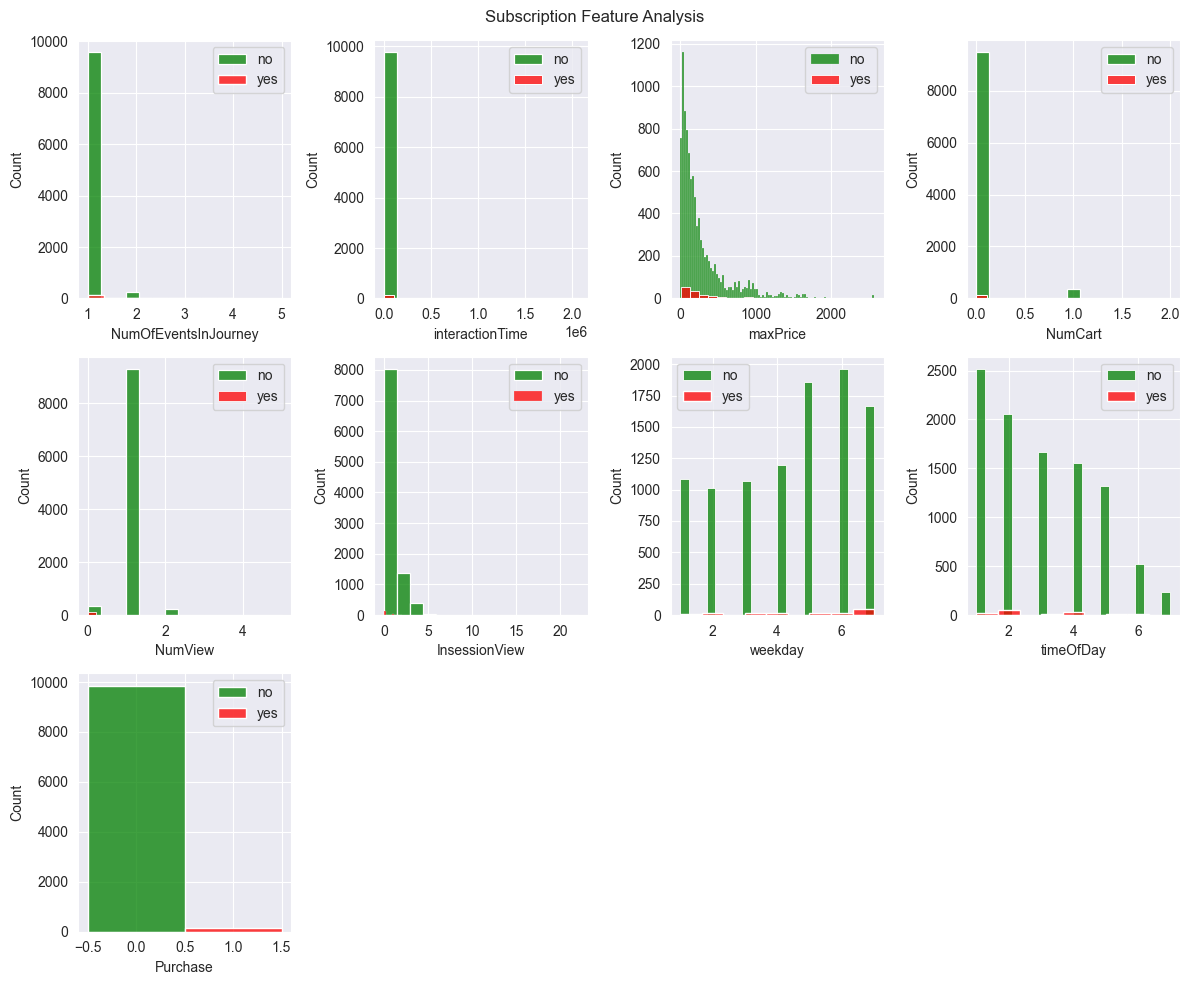

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
train_small_df_reduced = train_small_df[selected_columns]
fig = plt.figure(figsize=(12, 10))
j = 0
for i in train_df_reduced.columns:
    plt.subplot(3, 4, j + 1)
    j += 1
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 0], color='g', label='no')
    sns.histplot(train_small_df_reduced[i][train_small_df_reduced['Purchase'] == 1], color='r', label='yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95);

6. Make the NumPy arrays `X_train_reduced`, `X_test_reduced`, `y_train` and `y_test` from `train_df_reduced` and `test_df_reduced`. 

In [24]:
y_train = train_df_reduced['Purchase'].values
y_test = test_df_reduced['Purchase'].values
X_train_reduced = train_df_reduced.drop(columns='Purchase').values
X_test_reduced = test_df_reduced.drop(columns='Purchase').values

7. Scale the features in `X_train_reduced` and `X_test_reduced` use `MinMaxScaler`

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_reduced = scaler.fit_transform(X_train_reduced)
X_test_reduced = scaler.fit_transform(X_test_reduced)

In [26]:
my = pd.DataFrame(X_train_reduced)
my.describe()

,0,1,2,3,4,5,6,7
count,645816.000000,645816.000000,645816.000000,645816.000000,645816.000000,645816.000000,645816.000000,645816.000000
mean,0.003021,0.002303,0.113231,0.005137,0.108105,0.017619,0.574867,0.323778
std,0.018348,0.028170,0.138424,0.024153,0.031473,0.012877,0.326221,0.276593
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.026600,0.000000,0.111111,0.014706,0.333333,0.000000
50%,0.000000,0.000000,0.063899,0.000000,0.111111,0.014706,0.666667,0.333333
75%,0.000000,0.000000,0.139988,0.000000,0.111111,0.014706,0.833333,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Task 4: Build Logistic Regression and SVM models

We will be fitting both a Logistic Regression and SVM model to the reduced features and then looking at classification metrics such as Accuracy, Precision, Recall, and F1-score.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score as accuracy,
    recall_score as recall,
    precision_score as precision,
    f1_score
)

1. Instantiate, train, and predict using the Logistic Regression model.

    Make sure to account for the imbalanced classes with `class_weight` parameter (what happens if we don't?).

    Remember to use the ***train*** data for training the model and the ***test*** data when making predictions.

In [28]:
%%time
lr_model = LogisticRegression(random_state=0, class_weight='balanced').fit(X_train_reduced, y_train)
lr_pred = lr_model.predict(X_test_reduced)

CPU times: user 11.3 s, sys: 6.31 s, total: 17.7 s
Wall time: 3.31 s


2. Calculate these classification metrics for the Logistic Regression model:

    * accuracy
    * precision
    * recall
    * f1 score
    * confusion matrix

In [29]:
print("accuracy:", accuracy(y_test, lr_pred))
print("precision:", precision(y_test, lr_pred))
print("recall:", recall(y_test, lr_pred))
print("f1 score:", f1_score(y_test, lr_pred))
print("confusion matrix:")
print(confusion_matrix(y_test, lr_pred))

accuracy: 0.9603176446542049
precision: 0.2636547829460706
recall: 0.9993464052287582
f1 score: 0.4172323225432343
confusion matrix:
[[407343  17081]
 [     4   6116]]


3. Instantiate, train and predict using the SVM model. Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for usage. 

    Again, remember to account for the class imbalance.

In [30]:
%%time
svm_model = LinearSVC(random_state=0, class_weight='balanced')
svm_model.fit(X_train_reduced, y_train)
svm_pred = svm_model.predict(X_test_reduced)

CPU times: user 2min 15s, sys: 1.29 s, total: 2min 16s
Wall time: 2min 21s


/Users/yingkang/miniconda3/envs/supervisedML/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


4. ❓ What is the time complexity of SVM? What is it for Logistic Regression? Not familiar with the term "time complexity"? Take a read on [Computational Complexity of ML Models
](https://medium.com/analytics-vidhya/time-complexity-of-ml-models-4ec39fad2770)

    YOUR ANSWER HERE
   Assume: n = # of training examples, d = # of dimensions of data
   Time complexity of SVM = O(nd)
   Time complexity of Logistic Regression = O(n^2)
   This can also explain why it costs longer time to train the SVM

5. Calculate the classification metrics for the SVM model. 

Here you can use a helper function to display all the metrics. 

Inspect the source code to understand how to use the function. 

In [31]:
from utils import display_metrics
display_metrics(y_test, svm_pred)

Confusion Matrix: 
[[424036    388]
 [     1   6119]]
Accuracy: 0.999
Recall: 1.000
Precision: 0.940
F1 Score: 0.969


Wow, that's impressive! Why do you think SVM performs so well? If you are not familiar with Support Vector Machine, check [In-Depth: Support Vector Machines](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb) out for better understanding. 

## Task 5: Explanability with SHAP

Interpretation of a linear model such as logistic regression is straightforward, however, some tree-based models have a different reputation. In this task, we will fit a non-linear classifier: begin with gradient boosted tree, and use SHAP to help interpret the model.

1. What are training coefficients from logistic regression? ( how about SVM? check [How does one interpret SVM feature weights?](https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights) )

    Leave your comments on interpretation of this logistic regression model.

In [32]:
lr_model.coef_

array([[ 9.54385126e+01,  5.57479214e+00,  1.35547654e-01,
        -7.27205640e+01, -8.95649678e+01, -1.53870885e+01,
         9.43292739e-02,  2.43039499e-02]])

In [33]:
# YOUR CODE HERE
pd.DataFrame(zip(train_df_reduced.drop(columns='Purchase').columns, np.transpose(lr_model.coef_)), columns=['features', 'coef'])

,features,coef
0,NumOfEventsInJourney,[95.43851259708069]
1,interactionTime,[5.574792135019595]
2,maxPrice,[0.13554765412587047]
3,NumCart,[-72.7205640238532]
4,NumView,[-89.56496776493229]
5,InsessionView,[-15.387088539360699]
6,weekday,[0.09432927389130365]
7,timeOfDay,[0.02430394993523889]


In [34]:
print("Features coefficients: \n")
for i in range(train_df_reduced.shape[1]-1):
    print(train_df_reduced.columns[i], "=", lr_model.coef_[0][i])

Features coefficients: 

NumOfEventsInJourney = 95.43851259708069
interactionTime = 5.574792135019595
maxPrice = 0.13554765412587047
NumCart = -72.7205640238532
NumView = -89.56496776493229
InsessionView = -15.387088539360699
weekday = 0.09432927389130365
timeOfDay = 0.02430394993523889


2. Instantiate, train, and predict using the Gradient Boosted Trees model.

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

In [36]:
%%time
gbt_model = GradientBoostingClassifier(random_state=0)
gbt_model.fit(X_train_reduced, y_train)
gbt_pred = gbt_model.predict(X_test_reduced)

CPU times: user 44.9 s, sys: 3.23 s, total: 48.2 s
Wall time: 48.8 s


3. Evaluate the model by calculating the classification metrics.

In [37]:
display_metrics(y_test, gbt_pred)

Confusion Matrix: 
[[424136    288]
 [   108   6012]]
Accuracy: 0.999
Recall: 0.982
Precision: 0.954
F1 Score: 0.968


4. SHAP (SHapley Additive exPlanations) is a game theory approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. You can use package [SHAP](https://github.com/slundberg/shap). 

    For this task, if you are not familar with the concept, read the book chapter [Interpretable Machine Learning - A Guide for Making Black Box Models Explainable](https://christophm.github.io/interpretable-ml-book/shap.html) first. 

5. Consider experimenting on a smaller dataset. 

For example, start with a subset of 100 samples from the test data.

Once the script works properly, use all the data from `X_test_reduced`. 

Apply `shap.Explainer()` to calculate the SHAP values for the Gradient Boosting classifier you fit earlier.

In [38]:
np.random.seed(123)
subset_size = 100 # X_test_reduced.shape[0] # start with 100
idx = np.random.randint(X_test_reduced.shape[0], size=subset_size)
X_test_reduced_subset = X_test_reduced[idx, ]

assert X_test_reduced_subset.shape == (subset_size, 8)

In [39]:
import shap
# explainer = shap.Explainer(gbt_model, X_test_reduced_subset)
explainer = shap.Explainer(gbt_model.predict, X_test_reduced_subset)

In [40]:
%%time
shap_values = explainer(X_test_reduced_subset)

CPU times: user 3.71 s, sys: 361 ms, total: 4.07 s
Wall time: 4.21 s


6. visualize the effects over all samples using `shap.plots.beeswarm()` or `shap.summary_plot()`. 

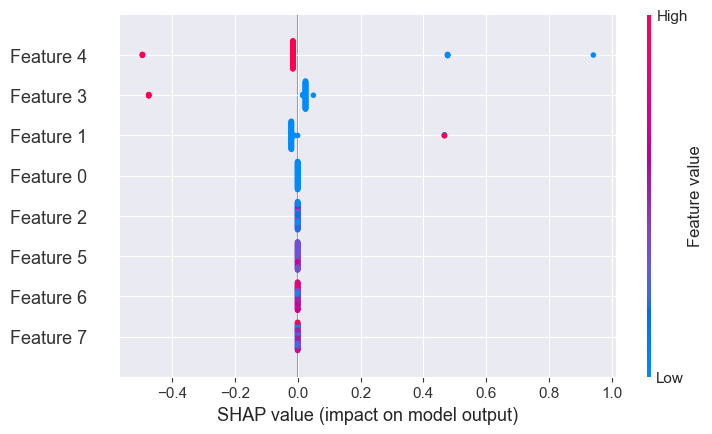

In [41]:
shap.plots.beeswarm(shap_values)

7. What are features 4, 3, and 1? Does each feature positively or negatively contribute to the likelihood of purchase?

Features 4, 3, and 1 are 'NumView', 'NumCart', 'interactionTime'. They are 3 most important features(in descending order) affect the prediction.
Feature 4 and 3 ('NumView' and 'NumCart') negatively contribute to the likelihood of purchase.
Feature 1 ('interactionTime') positively contribute to the likelihood of purchase.

In [42]:
test_df_reduced.drop(columns='Purchase').columns

Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'weekday', 'timeOfDay'],
      dtype='object')

8. Visualize the effects over all samples using `shap.plots.beeswarm()` or `shap.summary_plot()`.

In [303]:
# start from small dataset
# todo - switch to all data in X
np.random.seed(123)
subset_size = 100 # X_test_reduced.shape[0]
idx = np.random.randint(X_test_reduced.shape[0], size=subset_size)
X_test_reduced_subset = X_test_reduced[idx, ]

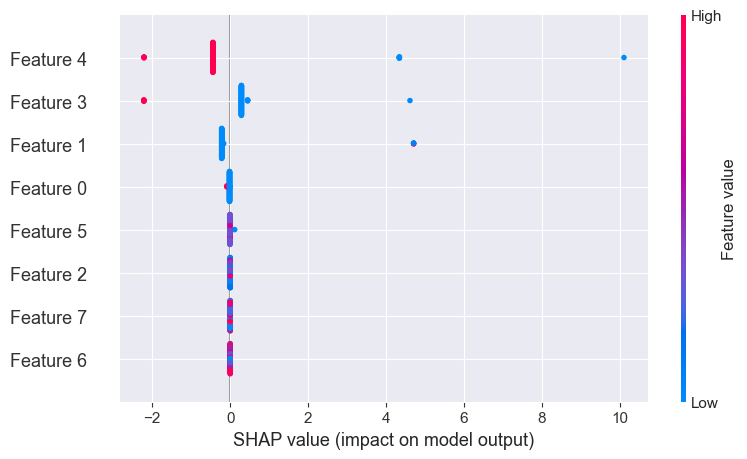

CPU times: user 1.18 s, sys: 395 ms, total: 1.58 s
Wall time: 741 ms


In [304]:
%%time
plt.close()
#instantiate shap explainer
gbt_explainer = shap.Explainer(gbt_model)
gbt_shap_values = gbt_explainer.shap_values(X_test_reduced_subset)
#plot and save global explanation
shap.summary_plot(gbt_shap_values, X_test_reduced_subset, show=False)
plt.savefig('../dat/gbt_global.png')    #save gbt_global plot fig
plt.close()

shap.summary_plot(gbt_shap_values, X_test_reduced_subset, title='GBT_Global')

9. Write your data (shap values) to a file and add them under the Model Explainability tab in the Streamlit app (see next section), following the example in Model Results tab.

In [306]:
import random
rand_sample = random.randint(0, 99) #X_test_reduced.shape[0]-1
print(rand_sample)

90


In [307]:
# plot local explanation
shap.initjs()

shap.force_plot(gbt_explainer.expected_value, gbt_shap_values[rand_sample], X_test_reduced_subset[[rand_sample]], show=False, matplotlib=True).savefig('../dat/gbt_local.png')

shap.force_plot(gbt_explainer.expected_value, gbt_shap_values[rand_sample], X_test_reduced_subset[[rand_sample]])

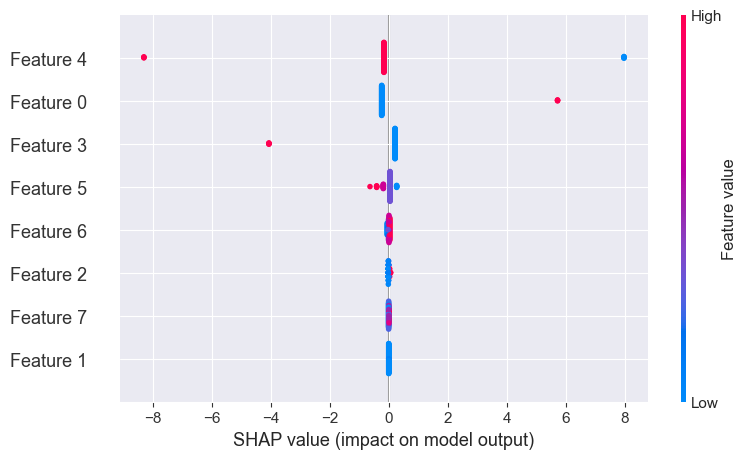

In [308]:
plt.close()
#lr_model
lr_explainer = shap.LinearExplainer(lr_model, X_test_reduced_subset)
lr_shap_values = lr_explainer.shap_values(X_test_reduced_subset)

shap.summary_plot(lr_shap_values, X_test_reduced_subset, show=False)
plt.savefig('../dat/lr_global.png')
plt.close()

shap.summary_plot(lr_shap_values, X_test_reduced_subset)

In [309]:
shap.force_plot(lr_explainer.expected_value, lr_shap_values[rand_sample], X_test_reduced_subset[[rand_sample]], show=False, matplotlib=True).savefig('../dat/lr_local.png')

shap.force_plot(lr_explainer.expected_value, lr_shap_values[rand_sample], X_test_reduced_subset[[rand_sample]])

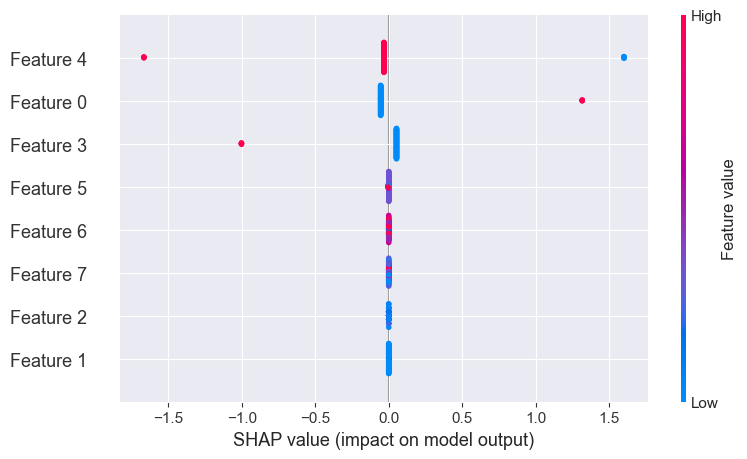

In [310]:
plt.close()
#svm_model
svm_explainer = shap.LinearExplainer(svm_model, X_test_reduced_subset)
svm_shap_values = svm_explainer.shap_values(X_test_reduced_subset)

shap.summary_plot(svm_shap_values, X_test_reduced_subset, show=False)
plt.savefig('../dat/svm_global.png')
plt.close()

shap.summary_plot(svm_shap_values, X_test_reduced_subset)

In [311]:
shap.force_plot(svm_explainer.expected_value, svm_shap_values[rand_sample], X_test_reduced_subset[[rand_sample]], show=False, matplotlib=True).savefig('../dat/svm_local.png')

shap.force_plot(svm_explainer.expected_value, svm_shap_values[rand_sample], X_test_reduced_subset[[rand_sample]])

10. Optional. Do the same for a random forest model.

## Task 6: AutoML

Let's see how AutoML performs on this imbalanced dataset. Similarly, for faster iteration on our workflow, experiment it on a small smaple. 

1. Take 5,000 samples from `train_df`, 5,000 from `test_df` for experimenting.

In [58]:
train_features = train_df.sample(int(5e3), random_state=42)
train_label = train_features.pop('Purchase')
test_features = test_df.sample(int(5e3), random_state=42)
test_label = test_features.pop('Purchase')

2. Instantiate and train a TPOT auto-ML classifier.

    The parameters in the code below are set to low values for faster iterations. 
    Read about each parameters [here](http://epistasislab.github.io/tpot/api/#classification) and experiment with different values when time permits.
    
    Set a proper [`scoring` function](http://epistasislab.github.io/tpot/using/#scoring-functions). 

In [59]:
%%time
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=10, 
                      population_size=16,
                      scoring='f1_weighted',# YOUR CODE HERE
                      verbosity=2,
                      random_state=42)
tpot.fit(train_features, train_label)
print(f"Tpop score on test data: {tpot.score(test_features, test_label):.2f}")
tpot.export('tpot_electronics_pipeline.py')

Optimization Progress:   0%|          | 0/176 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9985503545768799

Generation 2 - Current best internal CV score: 0.9985503545768799

Generation 3 - Current best internal CV score: 0.9997963469805334

Generation 4 - Current best internal CV score: 0.9997963469805334

Generation 5 - Current best internal CV score: 0.9997963469805334

Generation 6 - Current best internal CV score: 0.9997963469805334

Generation 7 - Current best internal CV score: 0.9997963469805334

Generation 8 - Current best internal CV score: 0.9998033975401949

Generation 9 - Current best internal CV score: 1.0

Generation 10 - Current best internal CV score: 1.0

Best pipeline: RandomForestClassifier(FastICA(MaxAbsScaler(input_matrix), tol=0.65), bootstrap=False, criterion=gini, max_features=0.45, min_samples_leaf=3, min_samples_split=20, n_estimators=100)
Tpop score on test data: 1.00
CPU times: user 18min 48s, sys: 5min 1s, total: 23min 49s
Wall time: 7min 7s


sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.


3. Examine the model pipeline that TPOT classifier offers in the python file `tpot_electronics_pipeline.py` in the `nb` directory. 
If you see any model, function, or class that are not familiar, look them up!

    Note: There is randomness to the way the TPOT searches, so it's possible you won't have exactly the same result as your classmate.

In [46]:
!cat tpot_electronics_pipeline.py # A sample output

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: 1.0
exported_pipeline = make_pipeline(
    PCA(iterated_power=8, svd_solver="randomized"),
    XGBClassifier(learning_rate=1.0, max_depth=10, min_child_weight=12, n_estimators=100, n_jobs=1, subsample=0.45, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_stat

4. Take the appropriate lines (e.g., updating path to data and the variable names) from `tpot_electronics_pipeline.py` to build a model on our training set and make predictions on the test set. 

    Choose approriate metrics to evaluate the prediction from TPOT. 
    
    Optional. Add this to Streamlit `models` in the next section.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from tpot.export_utils import set_param_recursive

train_df = pd.read_csv('../dat/train.csv.gz', compression='gzip')
training_features = train_df.drop('Purchase', axis=1)
training_target = train_df['Purchase']
test_df = pd.read_csv('../dat/test.csv.gz', compression='gzip')
testing_features = test_df.drop('Purchase', axis=1)
testing_target = test_df['Purchase']

# Average CV score on the training set was: 1.0
exported_pipeline = make_pipeline(
    PCA(iterated_power=8, svd_solver="randomized"),
    XGBClassifier(learning_rate=1.0, max_depth=10, min_child_weight=12, n_estimators=100, n_jobs=1, subsample=0.45, verbosity=0)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

display_metrics(testing_target, results)

## Advanced Visualizations with Streamlit and Plotly!
Let's visualize our results in a way that makes it easy to compare our models!  
[Streamlit](https://streamlit.io/) is a Python package that makes it easy to create bespoke, dynamic and interactive web apps for visualizations.  
Lightweight web apps like this are a great way to present results to stakeholders! 

First we need to build our results dataset to render in Streamlit.

In [113]:
from collections import defaultdict

results_data = defaultdict(list)

models = ["Logistic Regression", "SVM", "Gradient Boosting Classifier"]

for model, pred in zip(models, [lr_pred, svm_pred, gbt_pred]):
    confusion = confusion_matrix(y_test, pred)
    accuracy_ = accuracy(y_test, pred)
    recall_ = recall(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    results_data['model'].append(model)
    results_data['tn'].append(confusion[0][0])
    results_data['fp'].append(confusion[0][1])
    results_data['fn'].append(confusion[1][0])
    results_data['tp'].append(confusion[1][1])
    results_data['accuracy'].append(accuracy_)
    results_data['recall'].append(recall_)
    results_data['f1_score'].append(f1)
results_df = pd.DataFrame(results_data)
results_df

,model,tn,fp,fn,tp,accuracy,recall,f1_score
0,Logistic Regression,407343,17081,4,6116,0.960318,0.999346,0.417232
1,SVM,424036,388,1,6119,0.999096,0.999837,0.969193
2,Gradient Boosting Classifier,424136,288,108,6012,0.999080,0.982353,0.968116


In [114]:
# Write our results_df to CSV
results_df.to_csv("../dat/model_results.csv")

2. Then, we need to built Stremlit app. 
For today's assignment, we wrote the code for you.
However, understand the code in `electronics_purchase_predictions_stremlit.py` because you might need to write a Streamlit web app on your own for the future assignments. 

3. Once you inspected the code, you will need to start streamlit from CLI. 
Try looking up how to do this yourself.

HINT: this is a python file - maybe if you run it as a python file from the CLI, it will give you further instructions. 

Note - once you run the stremlit, the prompt will ask you to provide an email. 
You can leave the email blank. 

And you are done! 

## References

- This work is motivated by this [publication](https://arxiv.org/pdf/2010.02503.pdf) 
- [Comprehensive Guide on Feature Selection](https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection/notebook)
- [Common pitfalls and recommended practices](https://scikit-learn.org/stable/common_pitfalls.html)
- [Interactive Shapley Value Demonstration in Python](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/Interactive_Shapley_Values.ipynb)
- [Subsurface Data Analytics](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Feature_Ranking.ipynb)

### Algorithm Understanding
1. Is SVM (Support Vector Machine) a supervised or unsupervised learning algorithm?
Why is SVM such a powerful classification method?
What are 3 disadvantages of SVMs?

Answer: SVM is a supervised learning algorithm. It's a powerful classification method for a number of reasons:
Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
Once the model is trained, the prediction phase is very fast.
Because they are affected only by points near the margin, they work well with high-dimensional data, even data with more dimensions than samples, which is a challenging regime for other algorithms.
Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:
The scaling with the number of samples  is  at worst, or  for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
The results are strongly dependent on a suitable choice for the softening parameter . This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the probability parameter of SVC), but this extra estimation is costly.

### Interview Readiness
2. What is the time complexity of SVM?
   What is it for Logistic Regression?

Answer:
n = # of training examples, d = # of dimensions of data
Time complexity of SVM = O(nd)
Time complexity of Logistic Regression = O(n^2)

3. Explain feature importance for the Random Forest algorithm?
   When examining feature importance, what is Gini impurity or information gain?

Answer:
Random Forest is a set of Decision Trees. Each Decision Tree is a set of internal nodes and leaves. In the internal node, the selected feature is used to make decision how to divide the data set into two separate sets with similar responses within. The features for internal nodes are selected with some criterion, which for classification tasks can be gini impurity or information gain. We can measure how each feature decrease the impurity of the split (the feature with the highest decrease is selected for internal node). For each feature we can collect how on average it decreases the impurity. The average over all trees in the forest is the measure of the feature importance.
Gini impurity is a measure of impurity of a node. Information gain is the Gini impurity of parent node minus sum of weighted Gini impurities of child nodes. When examining feature importance, we calculate the information gain for each feature, and the feature with highest information gain value is the selected(most important) feature.

4. SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model, what is it and how does it work?

Answer:
SHAP is a method to explain individual predictions. SHAP is based on the game theoretically optimal Shapley values.

The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the “payout” (= the prediction) among the features.
Shapley value for each variable (payout) is basically trying to find the correct weight such that the sum of all Shapley values is the difference between the predictions and average value of the model. In other words, Shapley values correspond to the contribution of each feature towards pushing the prediction away from the expected value.